In [2]:
import matplotlib
%matplotlib inline

import PreFRBLE
from PreFRBLE.convenience import *
from PreFRBLE.plot import *
from PreFRBLE.likelihood import *
from PreFRBLE.physics import *


# Basic Usage

Here we explain the basic usage of PrEFRBLE:
1. How to read likelihoods of individual models and realistic LoS scenarios
2. How to add likelihoods of new models
3. How to compute the likelihood of measurements in a scenario as well as the Bayes Factor

## Read Likelihood

We start with reading and plotting the likelihood $L$ of an individual model.
$L$ describes the probability density $P$ (100-array) of given measure with bin ranges $x$ (101-array) 
( $L$ stands for "likelihood", while $P$ usually stands for "posterior". 
However, $P$ is also used as general symbol for all kind of probability functions, thus it was chosen in the code).
$L$, is normalized such that $1 = \sum L \cdot \text{d}x$.
However, by default we plot $L(x)\cdot x$, such that the shape is identical to the probability of measures in logarithmic bins, which is easy to interpret, while the displayed values are physical and do not depend on the binning.

In order to read a likelihood from file, we first have to define a Scenario object, this works as identifier, and subsequently load $L$. 

/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:177: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5


1.0000000000000004


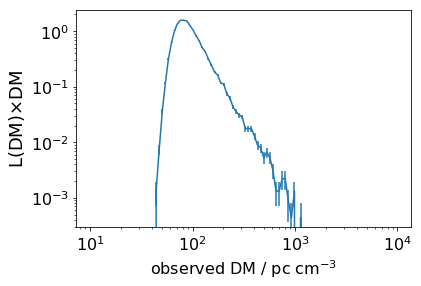

In [3]:
## in this example scenario we are interested in the contribution of the IGM to measures of FRBs hosted at redshift z=0.1
scenario = Scenario( IGM='primordial', redshift=0.1) 


## now we read the likelihood of DM expected in this scenario
measure = 'DM'
L = GetLikelihood( measure, scenario )

## this is given as a LikelihoodFunction object, which comes with a lot of handy functions, e. g. 
L.Plot()
plt.loglog()
print( L.Norm() )



The same function delivers likelihoods for all the other regions as well: Local, Host and Inter.
Basically, this function provides all likelihood funtions, also for full LoS scenarios as well as telescope expectations

In order to investigate realistic scenarios for full LoS, we convolve the likelihoods of measure in the different regions, e. g. 
$$ L(x) = L_1 \ast L_2 (x) = \int L_1(y) L_2(x-y) \text{d}y . $$
To read the resulting likelihood, we first need to define a scenario

In [6]:
## first, a list of the properties to be entailed

properties_benchmark = {  ## this is our benchmark scenario, fed to procedures as kwargs-dict of models considered for the different regions are provided as lists (to allow to consider multiple models in the same scenario, e. g. several types of progenitors. Use mixed models only when you kno what you are doing)
    'redshift' : 0.1, ## Scenario must come either with a redshift or a pair of telescope and redshift population
    'IGM' : ['primordial'],       ## constrained numerical simulation of the IGM (more info in Hackstein et al. 2018, 2019 & 2020 )
    'Host' : ['Rodrigues18'],     ## ensemble of host galaxies according to Rodrigues et al . 2018
    'Inter' : ['Rodrigues18'],    ## same ensemble for intervening galaxies
    'Local' : ['Piro18_wind'],    ## local environment of magnetar according to Piro & Gaensler 2018
    'N_inter' : True, ## if N_Inter = True, then intervening galaxies are considered realistically, i. e. according to the expecte number of intervened LoS N_inter
    'f_IGM' : 0.9,   ## considering baryon content f_IGM=0.9
}

scenario_benchmark = Scenario( **properties_benchmark )


With this, we can read out the full likelihood using the same function.
However, this can take a little while if it hasn't been computed yet, especially for non-absolute measures like RM.

/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:177: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5


(0.0001, 10)

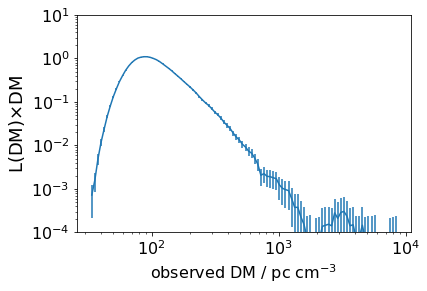

In [7]:
L = GetLikelihood( measure, scenario_benchmark )

L.Plot()
plt.loglog()
plt.ylim(1e-4,10)


In order to compare these predictions to observations made by telescopes, we have to consider the selection effects of the instrument and assume an intrinsic redshift distribution of FRBs. 
The estimated likelihood of measure is obtained by summing results of all redshifts, weighted by the expected amount of FRBs from that redshift $\pi(z)$, e. g.
$$
L(DM) = \int P(DM|z) \pi(z) \text{d}z .
$$ 
We obtain $\pi(z)$ using [FRBpoppy](https://github.com/davidgardenier/frbpoppy/tree/master/frbpoppy), see _notebooks/model/Gardenier20.ipynb_ for details. 
The result can be read out using

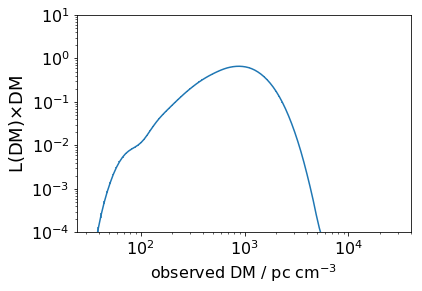

In [8]:
## we consider the same scenario, but instead of specific redshift, 
##   consider intrinsic redshift distribution of population and selection effects by telescope

telescope = 'CHIME'
population = 'SMD' ## for redshift distribution to follow Stellar Mass Density

scenario_telescope = Scenario( telescope=telescope, population=population, **scenario_benchmark.Properties( identifier=False ) )

L = GetLikelihood( measure, scenario_telescope )

L.Plot()
plt.loglog()
plt.ylim(1e-4,10)
plt.show()

This plot can be compared directly to the distribution of observed measures.

More convenient procedures concerning likelihoods can be found in the _Likelihood.ipynb_ notebook

## Write New Likelihood

We can easily add another model for individual regions.
For this, initialize the LikelihoodFunction with P, x, measure and scenario (which defines where to write).

In [9]:
P = np.zeros(100) ## probability density function
x = 10.**np.linspace(1,2,101) ## bin ranges
scenario = Scenario( redshift=0.1, IGM='whatever')  ## identifying scenario
measure='DM'
L = LikelihoodFunction( measure=measure, P=P, x=x, scenario=scenario ) ## create LikelihoodFunction object

## finally, write using
#L.Write()

## L can now be read using
# GetLikelihood( measure, scenario )


New likelihoods should match the form stated above.
However, $L$ can be obtained either via analytical description or from a model via Monte-Carlo simulation.
To obtain likelihoods from the resulting sample, simply use

In [10]:
N = 10**4
measures = np.random.rand(N)

L.Likelihood( measures, bins=100, log=True )

## The deviation is determined by the shot noise of the Monte-Carlo sample. This can be applied by
L.ShotNoise(N)


/data/prefrble/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/LikelihoodFunction.py:177: RuntimeWarning: divide by zero encountered in power
  self.dev =  ( self.Probability()*N )**-0.5


You can find more details on the models derived so far in the _notebooks/model/_ subdirectory.

## Compute Model Likelihood

Say we have a number of observations of unlocalized FRBs and want to see how likely they are produced in a certain scenario.
For this, we have to indicate the observing telescope, assume a redshift distribution and define the scenario in question.
For this, we read the likelihood $L$ expected to be observed and obtain the corresponding values of $L$ for the observed measures

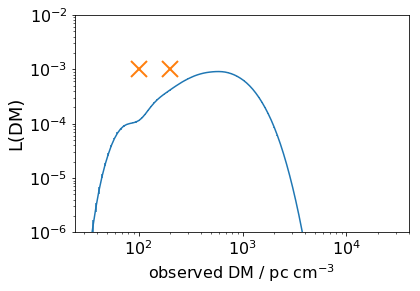

likelihoods [0.00011477 0.00041308] relative deviation [0.02564794 0.01660526]


In [19]:
measure='DM'
measurements = [1e2, 2e2]  ## example data

## we consider the benchark scenario, as observed by CHIME in the case of given redshift population
telescope = 'CHIME'
population = 'SMD' ## for redshift distribution to follow Stellar Mass Density
scenario = Scenario( telescope=telescope, population=population, **scenario_benchmark.Properties( identifier=False ) )
L = GetLikelihood( measure, scenario )

L.Plot(density=True)
plt.plot( measurements, [1e-3]*len(measurements), marker='x', markersize=16, markeredgewidth=2, linestyle=' ' )
plt.loglog()
plt.ylim(1e-6,1e-2)
plt.show()

likelihoods, deviations = L.Likelihoods( measurements=measurements, deviation=True )
print("likelihoods", likelihoods, "relative deviation", deviations)


A single likelihood does not entail any information on its own. 
Instead, the likelihoods for a single measure should be compared for competing scenarios.
This is done by the Bayes factor 
$$
\mathcal{B} = \frac{L_0}{L_1} .
$$
In order to compute $\mathcal{B}$ we repeat the above for a competing scenario and compute the ratio of $L$ (i. e. the probability density function, which has to be used instead of probability, in order to be independent on bin-size).

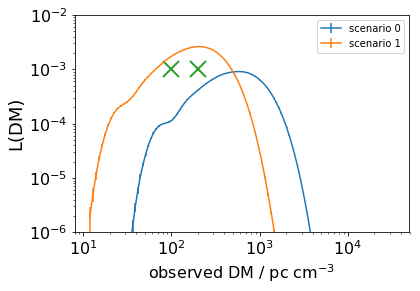

individual Bayes factors: [0.06360297 0.15759435] deviations [0.02873871 0.01900866]
Total Bayes = 0.010023468526105132, i. e. scenario0 is this much less likely to explain the observed measures 
relative deviation 0.0344563894101461


In [21]:

fig, ax = plt.subplots()

density=True  ## plot probability density

L.Plot( ax=ax, label='scenario 0', density=density )
plt.loglog()

scenario1 = scenario.copy()
scenario1.f_IGM = 0.3  ## choose IGM model with smaller baryon fraction f_IGM = 0.3

L1 = GetLikelihood( measure, scenario1 )
L1.Plot( ax=ax, label='scenario 1', density=density)


ax.plot( measurements, [1e-3]*len(measurements), marker='x', markersize=16, markeredgewidth=2, linestyle=' ' )
ax.set_ylim(1e-6,1e-2)
ax.legend()
plt.show()

likelihoods1, deviations1 = L1.Likelihoods( measurements=measurements, deviation=True )
bayes, bayes_dev = BayesFactors( P1=likelihoods, P2=likelihoods1, dev1=deviations, dev2=deviations1 )
print("individual Bayes factors:", bayes, "deviations", bayes_dev)
bayes_total, bayes_total_deviation = BayesFactor( P1=likelihoods, P2=likelihoods1, dev1=deviations, dev2=deviations1, mode="simple" )
print('Total Bayes = {}, i. e. scenario0 is this much less likely to explain the observed measures'.format(bayes_total), "\nrelative deviation", bayes_total_deviation )


Note that according to Bayes theorem, the Bayes factor still has to be multiplied by the ratio of prior for scenario 0 and scenario 1 in order to arrive at the ratio of posterior, which indicates whether scenario 0 can be ruled out in favour of scenario 1.

More applications can be found in the other notebooks

in order to compare to events listed in FRBcat, you can use the following function, which requires you to download the latest version from http://www.frbcat.org/ and place it in the main folder as _frbcat.csv_

In [10]:
GetFRBcat()

array([('FRB191108',  588.1  ,  52.  ,  474. ,       nan,     nan, 'Apertif'),
       ('FRB190907',  310.9  ,  53.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190604',  552.7  ,  32.  ,  -20. ,       nan,     nan, 'CHIME/FRB'),
       ('FRB190523',  760.8  ,  37.  ,    nan, 1.400e+00, 0.66   , 'DSA-10'),
       ('FRB190417', 1378.1  ,  78.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190303',  222.4  ,  29.  , -499.8,       nan,     nan, 'CHIME/FRB'),
       ('FRB190222',  460.6  ,  87.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190212',  651.1  ,  43.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190209',  424.6  ,  46.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190208',  579.9  ,  72.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190117',  393.3  ,  48.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB190116',  444.   ,  20.  ,    nan,       nan,     nan, 'CHIME/FRB'),
       ('FRB181228',  354.2  ,  5